In [1]:
import requests
from bs4 import BeautifulSoup
from time import sleep, time
from IPython.display import display
import pandas as pd
import numpy as np
import itertools
import random
import re
import nltk
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from sklearn.base import clone
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import visuals as vs
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Obtaining data through a web API

In [2]:
# Define a function for retrieving news headlines and article summaries via 
# News API (https://newsapi.org/) service
apiKey = "2da9421a26804779a3519f42dfff01c9"

def news_retriever(source, domain, start_date='2017-09-23', days=62):    
    """
    Take in news source, e.g. New York Times, Fox News, etc., its
    domain for English language news, start date and period in days
    following the start date. Return a json object, turn it into a 
    dictionary, select the relevant fields, select only English
    language news. Append the dictionary to a list and create a 
    dataframe. 
    """
    lod = []

    for day in pd.date_range(start_date, periods=days):
        url = ('https://newsapi.org/v2/everything?'
           'q=&'
           'sources='+source+'&'
           'from='+str(day)[:10]+'&'
           'to='+str(day)[:10]+'&'
           'language=en&'        
           'page=1&'
           'sortBy=publishedAt&'
           'apiKey=' + apiKey)
        response = requests.get(url)
        dictionary = response.json()
        articles = dictionary["articles"]
        for article in articles:
            ad = {}
            ad["author"] = article["author"]
            ad["date"] = article["publishedAt"][:10]
            ad["source"] = article["source"]["id"]
            ad["title"] = article["title"]
            ad["summary"] = article["description"]
            ad["url"] = article["url"]
            lod.append(ad)
        sleep(10)
    df = pd.DataFrame(lod)
    english_rows = df["url"].apply(lambda word: word[:len(domain)] == domain)
    df_english = df[english_rows]
    return df_english

In [62]:
# Retrieve news headlines and summaries for Breitbart News, New York Times, 
# Russia Today and Fox News and write to csv files
df_breitbart = news_retriever("breitbart-news", "http://www.breitbart.com")
df_breitbart.to_csv("breitbart.csv")

df_nyt = news_retriever("the-new-york-times", "https://www.nytimes.com")
df_nyt.to_csv("nyt.csv")

df_rt = news_retriever("rt", "https://www.rt.com")
df_rt.to_csv("rt.csv")

df_fox = news_retriever("fox-news", "http://www.foxnews.com")
df_fox.to_csv("fox.csv")

In [2]:
def clean_up_df(csv_file):
    """
    Process the csv file of a particular news source
    to select the relevant columns, remove duplicates
    and rows with missing values. 
    """
    df = pd.read_csv(csv_file, encoding="ISO-8859-1")
    df = df[["source", "title", "summary"]]
    df.drop_duplicates(subset="summary", inplace=True)
    df.drop_duplicates(subset="title", inplace=True)
    df.dropna()
    df = df[df.title.notnull()]
    df = df[df.summary.notnull()]
    return df

In [3]:
# Process the csv files of the four news sources
# and return dataframes
breitbart = clean_up_df("breitbart.csv")
nyt = clean_up_df("nyt.csv")
rt = clean_up_df("rt.csv")
fox = clean_up_df("fox.csv")

In [4]:
# Create a consolidated dataframe of all four news sources
# data for subsequent machine learning
df = pd.concat([nyt, breitbart, rt, fox], ignore_index=True)
print (df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3673 entries, 0 to 3672
Data columns (total 3 columns):
source     3673 non-null object
title      3673 non-null object
summary    3673 non-null object
dtypes: object(3)
memory usage: 86.2+ KB
None


,source,title,summary
0,the-new-york-times,Editorial Observer: The President Demands Sile...,"From left: Eli Harold, Colin Kaepernick and Er..."
1,the-new-york-times,Jeremy Corbyns Rise From Hapless Loser to Pot...,Labour Party leader Jeremy Corbyn during a cam...
2,the-new-york-times,A Celebrity Listing Crashes Japanese Exchange'...,"On Japan's newest exchange, fame can pay off. ..."
3,the-new-york-times,Six Burned in Acid Attack as Groups Clash in E...,A group of men sprayed a caustic substance in ...
4,the-new-york-times,Milo Yiannopoulos Still Plans to Speak at Berk...,A student group that was organizing a series o...


## Exploratory analysis of the data

### Explore the length of documents

In [5]:
# Calculate mean number of raw words in headlines
title_words = df.title.apply(lambda r: r.split(" "))
title_words_len = title_words.apply(lambda l: len(l))
"The average number of raw, unrpocessed words in news headlines is {:.1f}, min and max being {:.1f} and {:.1f}, respectively" \
.format(title_words_len.mean(), title_words_len.min(), title_words_len.max())

'The average number of raw, unrpocessed words in news headlines is 11.2, min and max being 2.0 and 26.0, respectively'

In [6]:
# Calculate mean number of raw words in summaries
summary_words = df.summary.apply(lambda r: r.split(" "))
summary_words_len = summary_words.apply(lambda l: len(l))
"The average number of raw, unrpocessed words in news summaries is {:.1f}, min and max being {:.1f} and {:.1f}, respectively" \
.format(summary_words_len.mean(), summary_words_len.min(), summary_words_len.max())

'The average number of raw, unrpocessed words in news summaries is 31.4, min and max being 4.0 and 53.0, respectively'

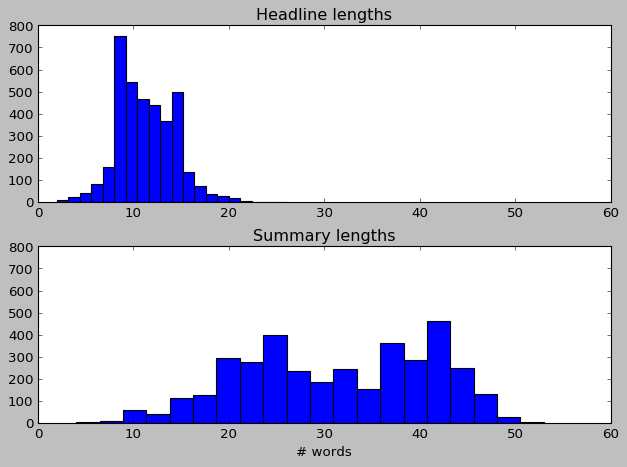

In [12]:
# Plot histograms of headline and summary lengths
plt.style.use("classic")
plt.subplot(2, 1, 1)
title_words_len.hist(bins=20, grid=False)
plt.xlim(0, 60)
plt.ylim(0, 800)
plt.title("Headline lengths")
plt.subplot(2, 1, 2)
summary_words_len.hist(bins=20, grid=False)
plt.xlim(0, 60)
plt.ylim(0, 800)
plt.title("Summary lengths")
plt.xlabel("# words")
plt.tight_layout(h_pad=0.7)
plt.savefig("title_summary_lengths.png")

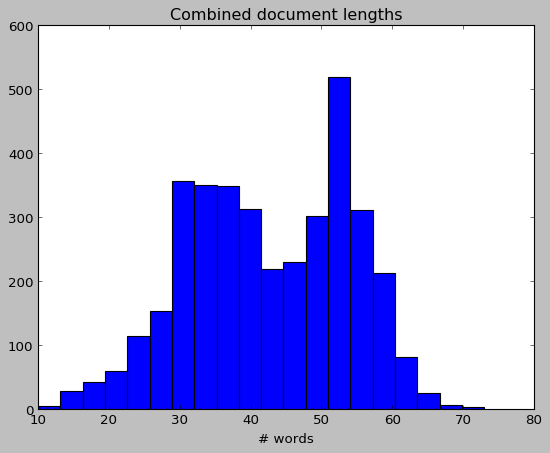

In [13]:
# Combine the headline and summary lengths and explore 
combined = title_words_len+summary_words_len
combined.hist(bins=20, grid=False)
plt.title("Combined document lengths")
plt.xlabel("# words")
plt.savefig("combined_document_lengths.png")

### Get a feel for the vocabulary and topics

In [7]:
def aggregate_docs(df, tuple_ind):
    """
    Lump the text in the cells of a given 
    column of a dataframe into a single document 
    for subsequent analysis of words. 
    """
    str = ''
    for row in df.itertuples():
        str += ' ' + row[tuple_ind]
    return str

In [8]:
# Create a single document for titles and summaries
# for each news sourcs
nyt_titles = aggregate_docs(nyt, 2)
nyt_summaries = aggregate_docs(nyt, 3)
breitbart_titles = aggregate_docs(breitbart, 2)
breitbart_summaries = aggregate_docs(breitbart, 3)
rt_titles = aggregate_docs(rt, 2)
rt_summaries = aggregate_docs(rt, 3)
fox_titles = aggregate_docs(fox, 2)
fox_summaries = aggregate_docs(fox, 3)

In [9]:
# Create an augmented list of stopwords 
sw = nltk.corpus.stopwords.words('english')
sw = set(sw + list(ENGLISH_STOP_WORDS))
sw = set(list(sw) + ["new", "york", "times", "breitbart", "news", "rt", "op", "ed", "editorial", "columnist", "opinion", 
                     "contributor", "fox", "say", "says", "said", "las", "video", "Letters", "letters", "mr", "read", 
                     "article", "com", "year", "report"])
len(sw)

378

In [10]:
# Text tokenization functions
porter_stemmer = PorterStemmer()

def tokenizer_stemmer(doc):
    """
    Tokenize into lowercase, alphabetical, non-stopword
    stemmed tokens. 
    """
    tokens = re.findall("\w\w+", doc)
    tokens_lower = [token.lower() for token in tokens]
    tokens_alpha = [token for token in tokens_lower if token.isalpha()]
    tokens_nosw = [token for token in tokens_alpha if token not in sw]
    tokens_stemmed = [porter_stemmer.stem(token) for token in tokens_nosw]
    return tokens_stemmed

def wordfreq(text):
    """
    Take in text and return a bag-of-words 
    of stemmed tokens. 
    """
    tokens_stemmed = tokenizer_stemmer(text)
    #freqdist = nltk.FreqDist(tokens_stemmed)
    freqdist = Counter(tokens_stemmed)
    return freqdist

def wordplot(text, top_n):
    """
    Take in text and plot a frequency plot
    of top n most frequent stemmed tokens. 
    """
    tokens_stemmed = tokenizer_stemmer(text)
    freqdist = nltk.FreqDist(tokens_stemmed)
    freqdist.plot(top_n)

def cell_text_converter(cell_text):
    """
    Take in original text and return a text 
    composed of concatenated lowercase, alphabetical, 
    non-stopword, stemmed tokens. 
    """
    tokens_stemmed = tokenizer_stemmer(cell_text)
    return ' '.join(tokens_stemmed)

In [11]:
# Inspect the top 15 tokens in the news titles and summaries of respective media sources
top = 15
docs = {"NYT titles": nyt_titles, 
        "NYT summaries": nyt_summaries, 
        "Breitbart titles": breitbart_titles, 
        "Breitbart summaries": breitbart_summaries, 
        "RT titles": rt_titles, 
        "RT summaries": rt_summaries, 
        "Fox titles": fox_titles, 
        "Fox summaries": fox_summaries} 

for doc in sorted(docs.items()): 
    print ("{}: most common {} tokens from a total of {}: \n{}" 
           .format(doc[0], top, len(wordfreq(doc[1])), wordfreq(doc[1]).most_common(top)))
    print ("\n")

Breitbart summaries: most common 15 tokens from a total of 4796: 
[('trump', 295), ('presid', 294), ('state', 164), ('senat', 160), ('donald', 154), ('nation', 151), ('republican', 116), ('hous', 112), ('sexual', 97), ('democrat', 92), ('white', 90), ('sunday', 85), ('moor', 84), ('anthem', 81), ('nfl', 79)]


Breitbart titles: most common 15 tokens from a total of 3297: 
[('trump', 224), ('moor', 67), ('bannon', 56), ('roy', 55), ('protest', 54), ('nfl', 51), ('weinstein', 46), ('gop', 43), ('sexual', 43), ('senat', 41), ('anthem', 41), ('donald', 40), ('gun', 39), ('steve', 38), ('alleg', 37)]


Fox summaries: most common 15 tokens from a total of 3266: 
[('trump', 69), ('polic', 66), ('presid', 66), ('kill', 46), ('man', 41), ('sunday', 40), ('nation', 39), ('state', 37), ('woman', 36), ('old', 35), ('arrest', 34), ('sexual', 33), ('week', 33), ('investig', 32), ('peopl', 31)]


Fox titles: most common 15 tokens from a total of 1813: 
[('trump', 48), ('kill', 28), ('polic', 24), ('m

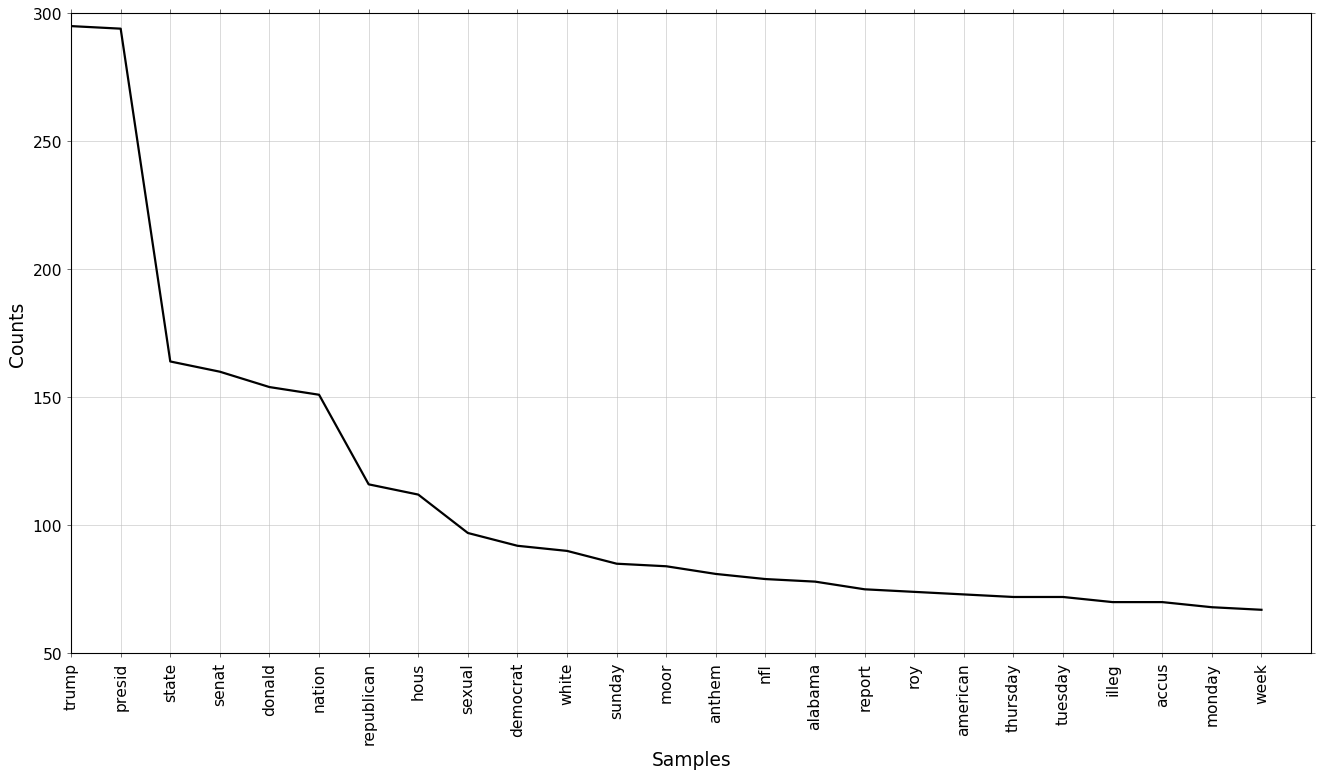

In [78]:
# Plot the top n most frequent stemmed tokens of a news source corpus
mpl.rcParams["font.size"] = 14
plt.figure(figsize=(20, 10), facecolor="white")
wordplot(breitbart_summaries, 25)
#fig.savefig("nltk_freqdist.png")

### Explore class distribution

In [11]:
# Distribution of the 4 classes
# We will use this for the definition of Naive classifier
class_dist = df.source.value_counts()
class_dist_perc = class_dist.apply(lambda x: x/class_dist.sum())
print (class_dist_perc)
max_class = class_dist_perc.max()

breitbart-news        0.331337
the-new-york-times    0.316635
rt                    0.214266
fox-news              0.137762
Name: source, dtype: float64


## Classification 

### Prepare a dataframe for supervised learning

In [12]:
# Each cell's text input is converted to text composed of 
# concatenated lowercase, alphabetical, non-stopword, 
# stemmed tokens. This will make the job easier for and 
# avoid having to set additional parameters for built-in
# text processing methods such as CountVectorizer
    
df["title"] = df["title"].apply(cell_text_converter)
df["summary"] = df["summary"].apply(cell_text_converter)
df["source"] = df["source"].map({ 'the-new-york-times' :0, 
                                'breitbart-news' : 1, 
                                'rt' : 2,
                                'fox-news' : 3})
# Add new comlumn which combines titles and summary for 
# each piece of news
df["combined"] = df.title + ' ' + df.summary
print (df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3673 entries, 0 to 3672
Data columns (total 4 columns):
source      3673 non-null int64
title       3673 non-null object
summary     3673 non-null object
combined    3673 non-null object
dtypes: int64(1), object(3)
memory usage: 114.9+ KB
None


,source,title,summary,combined
0,0,observ presid demand silenc colin kaepernick,left eli harold colin kaepernick eric reid san...,observ presid demand silenc colin kaepernick l...
1,0,jeremi corbyn rise hapless loser potenti leader,labour parti leader jeremi corbyn campaign ral...,jeremi corbyn rise hapless loser potenti leade...
2,0,celebr list crash japanes exchang parti,japan newest exchang fame pay great investor,celebr list crash japanes exchang parti japan ...
3,0,burn acid attack group clash east london,group men spray caustic substanc face latest s...,burn acid attack group clash east london group...
4,0,milo yiannopoulo plan speak berkeley event cancel,student group organ seri speech right wing act...,milo yiannopoulo plan speak berkeley event can...


### Define naive classifier

In [13]:
# The metrics are based on the rule of predicting the most prevalent
# class, i.e. Breitbart, all the time
accuracy = max_class
recall_max_class = 1.0
precision_max_class = max_class
# Note: all other class recalls are 0, hence all other class F1 also 0
# In a multi-class case, F1 is the weighted average of the F1 score of each class
# As all but max_class F1 are zero, the F1 of naive predictor is
fscore = max_class * 2 * (precision_max_class * recall_max_class) / (precision_max_class + recall_max_class)

print ("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.3313, F-score: 0.1649]


### Simple Bag-of-Words approach

In [14]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['combined'], 
                                                    df['source'],
                                                    test_size=0.25,
                                                    random_state=42)

print('Number of rows in the total set: {}'.format(df.shape[0]))
print('Number of rows in the training set: {}'.format(X_train.shape[0]))
print('Number of rows in the test set: {}'.format(X_test.shape[0]))

# Checking the class distribution of the test set
class_dist_y_test = y_test.value_counts()
class_dist_perc_y_test = class_dist_y_test.apply(lambda x: x/class_dist_y_test.sum())
print("Class distribution in test set:")
print (class_dist_perc_y_test)
# Test set class distribution is quite well aligned with the class distribution
# of the total dataset 

Number of rows in the total set: 3673
Number of rows in the training set: 2754
Number of rows in the test set: 919
Class distribution in test set:
0    0.343852
1    0.339499
2    0.200218
3    0.116431
Name: source, dtype: float64


In [23]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    ind = random.sample(range(len(X_train)), 300)
    # Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    #learner = None
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start 
        
    # Get the predictions on the test set,
    # then get predictions on 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[[ind]])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train.values[ind], predictions_train)
        
    # Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples
    results['f_train'] = f1_score(y_train.values[ind], predictions_train, average="weighted", \
                                  labels=np.unique(predictions_train))
        
    # TODO: Compute F-score on the test set
    results['f_test'] = f1_score(y_test, predictions_test, average="weighted", \
                                 labels=np.unique(predictions_test))
       
    # Success
    print ("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [20]:
# Prepare training and testing bag-of-words with sklearn's CountVectorizer
# NOTE: I put these back in a dataframe (vs. sparse matrix) to facilitate feature extraction later
count_vector = CountVectorizer(encoding="ISO-8859-1", max_features=None)
count_vector.fit(X_train)
words = count_vector.get_feature_names()
array = count_vector.transform(X_train).toarray()
train_vectors = pd.DataFrame(array, columns = words)
test_vectors = pd.DataFrame(count_vector.transform(X_test).toarray(), columns=words)
display(train_vectors.head(15))
print(train_vectors.shape)
display(test_vectors.head())
print(test_vectors.shape)

,aaron,ab,abadi,abandon,abba,abbi,abbott,abbottabad,abc,abd,...,zolani,zone,zoo,zookeep,zor,zucchini,zucker,zuckerberg,zumwalt,óscar
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(2754, 8884)


,aaron,ab,abadi,abandon,abba,abbi,abbott,abbottabad,abc,abd,...,zolani,zone,zoo,zookeep,zor,zucchini,zucker,zuckerberg,zumwalt,óscar
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(919, 8884)


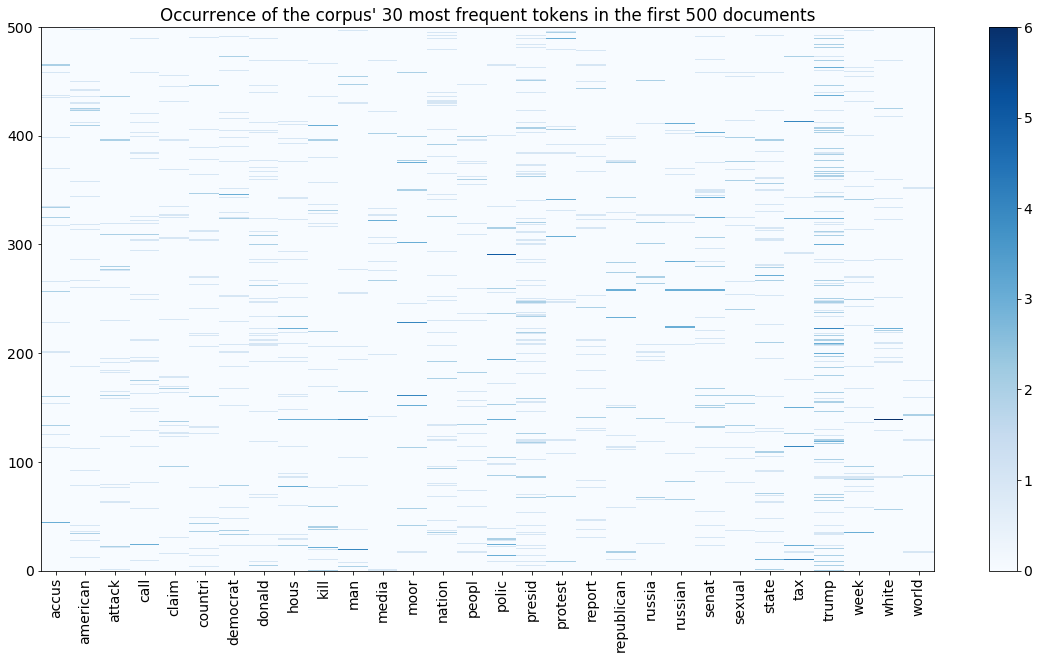

In [23]:
# Visualize BoW vectors - 30 most frequent 
#plt.style.use("grayscale")
# mpl.rcParams["font.size"] = 14
fig = plt.figure(figsize=(20, 10), facecolor="white")
fig.figsize=(20, 10)
plt.set_cmap("Blues")
plt.pcolor(train_vectors.iloc[:500, :], cmap="Blues")
x_loc = [i+0.5 for i in range(train_vectors.shape[1])]
plt.xticks(x_loc, train_vectors.columns, rotation="vertical")
plt.colorbar()
plt.title("Occurrence of the corpus' 30 most frequent tokens in the first 500 documents")

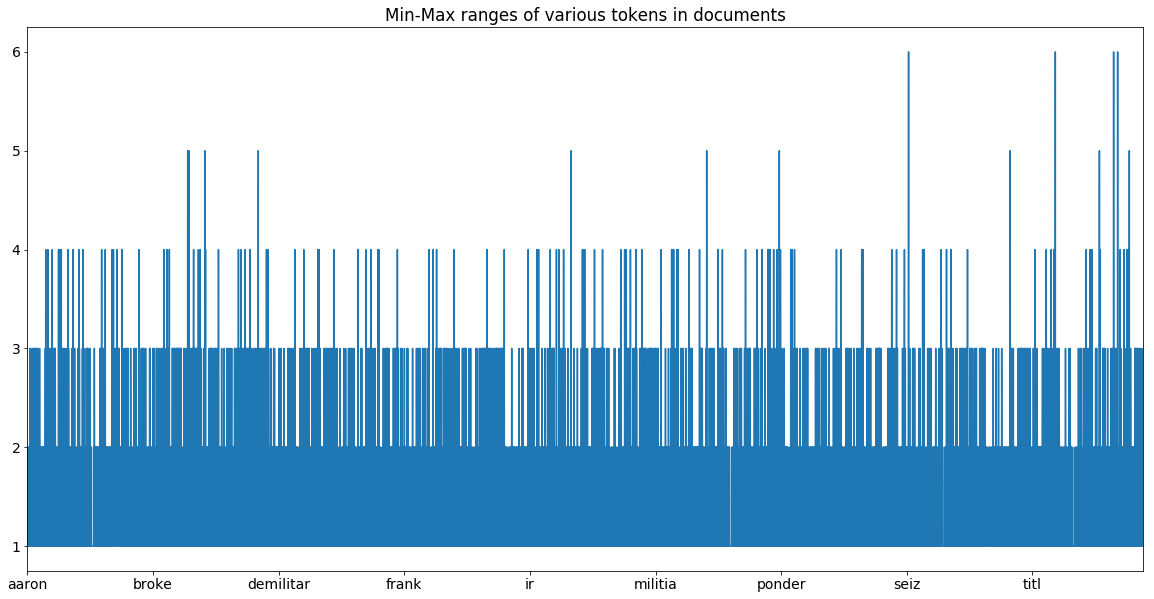

In [158]:
# Visualize BoG vectors - maximum word frequencies
train_vectors_totals = train_vectors.max()
plt.figure(figsize=(20, 10))
mpl.rcParams["font.size"] = 14
train_vectors_totals.plot()
plt.title("Min-Max ranges of various tokens in documents")

In [21]:
# Given the variable min-max ranges, I've decided to scale the features
scaler = MinMaxScaler()
#scaler = RobustScaler()
scaler.fit(train_vectors)
train_vectors = scaler.transform(train_vectors)
test_vectors = scaler.transform(test_vectors)

MultinomialNB trained on 688 samples.
MultinomialNB trained on 1652 samples.
MultinomialNB trained on 2754 samples.
LogisticRegression trained on 688 samples.
LogisticRegression trained on 1652 samples.
LogisticRegression trained on 2754 samples.
LinearSVC trained on 688 samples.
LinearSVC trained on 1652 samples.
LinearSVC trained on 2754 samples.


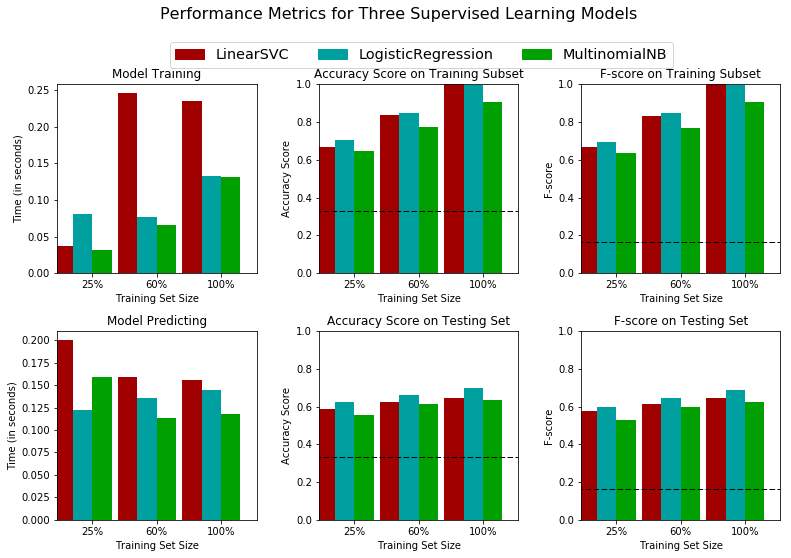

In [22]:
# Set candidate models
clf_A = MultinomialNB()
clf_B = LogisticRegression()
clf_C = LinearSVC(multi_class="crammer_singer")

# Calculate the number of samples for 25%, 60%, and 100% of the training data
samples_25 = int(0.25 * len(X_train))
samples_60 = int(0.60 * len(X_train))
samples_100 = len(X_train)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_25, samples_60, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, train_vectors, y_train, test_vectors, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

### Term frequency - Inverse document frequency approach

In [34]:
# Prepare training and testing bag-of-words with sklearn's TfidfVectorizer
# NOTE: I put these back in a dataframe (vs. sparse matrix) to facilitate feature extraction later
tfidf_vector = TfidfVectorizer(encoding="ISO-8859-1", min_df=0.0015, max_df=0.8)
tfidf_vector.fit(X_train)
words = tfidf_vector.get_feature_names()
array = tfidf_vector.transform(X_train).toarray()
train_vectors = pd.DataFrame(array, columns = words)
test_vectors = pd.DataFrame(tfidf_vector.transform(X_test).toarray(), columns=words)
display(train_vectors.head())
print(train_vectors.shape)
print("Corpus-specific stop words: {} " .format(None if not tfidf_vector.stop_words_ else tfidf_vector.stop_words_))
display(test_vectors.head())
print(test_vectors.shape)

,abandon,abc,abil,abl,abort,abus,academ,academi,accept,access,...,xi,yanke,ye,year,yemen,young,youtub,zimbabw,zone,zuckerberg
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.411619
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


(2754, 2297)
Corpus-specific stop words: {'chipset', 'rivet', 'backseat', 'emma', 'towel', 'identi', 'starbuck', 'dish', 'rapon', 'tattoo', 'van', 'untim', 'marrero', 'hockney', 'ramif', 'blown', 'truste', 'bruyn', 'legkov', 'megaproduc', 'ftom', 'snap', 'cinemark', 'talal', 'antic', 'ubiquit', 'holup', 'isol', 'disallow', 'luggag', 'consider', 'ministeri', 'compass', 'thewrap', 'threshold', 'tessier', 'retali', 'hawija', 'fmr', 'samsung', 'sproul', 'vaquita', 'uncontain', 'steroid', 'iron', 'shorti', 'latin', 'nkorea', 'shower', 'guidelin', 'infuri', 'allahu', 'depp', 'mine', 'creep', 'effici', 'laboratori', 'unfussi', 'nugget', 'robust', 'vestavia', 'bordeaux', 'cling', 'federico', 'fought', 'argument', 'superhero', 'krakoff', 'glider', 'print', 'mail', 'taper', 'top', 'unacknowledg', 'section', 'contenti', 'del', 'sensat', 'dorsey', 'barea', 'falcon', 'gratif', 'autopsi', 'commut', 'gelina', 'il', 'resp', 'driven', 'simpson', 'riley', 'stev', 'paley', 'repo', 'psaki', 'aldean', 'opt

,abandon,abc,abil,abl,abort,abus,academ,academi,accept,access,...,xi,yanke,ye,year,yemen,young,youtub,zimbabw,zone,zuckerberg
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(919, 2297)


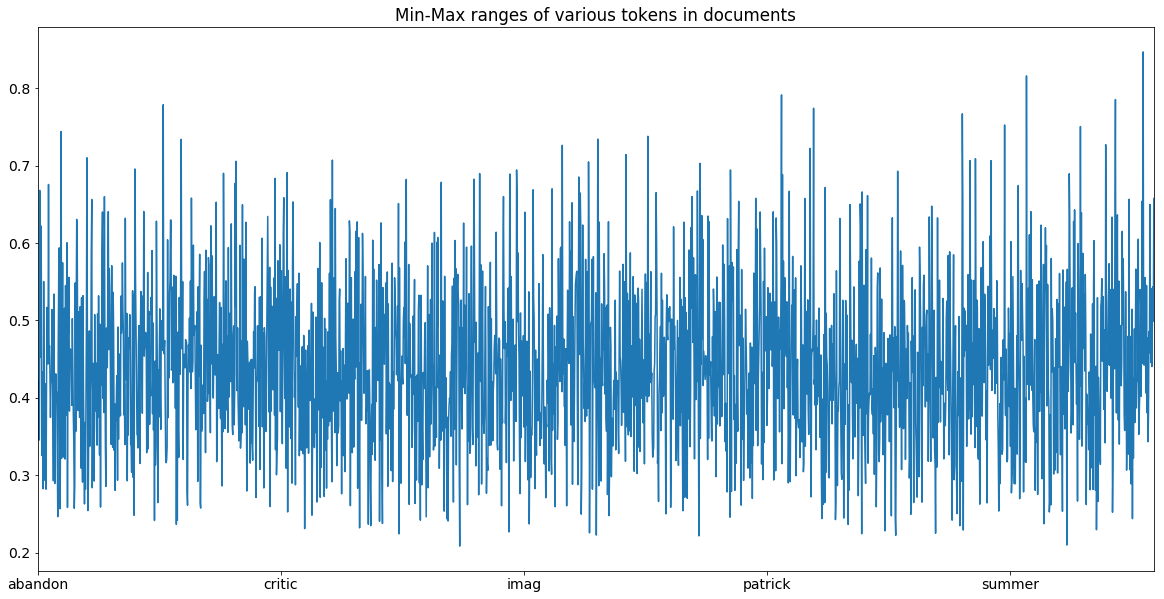

In [15]:
# Visualize TfIdf vectors max values
train_vectors_totals = train_vectors.max()
plt.figure(figsize=(20, 10))
mpl.rcParams["font.size"] = 14
train_vectors_totals.plot()
plt.title("Min-Max ranges of various tokens in documents")

In [25]:
# Convert TfIdf dataframes into arrays 
train_vectors = train_vectors.values
test_vectors = test_vectors.values

MultinomialNB trained on 688 samples.
MultinomialNB trained on 1652 samples.
MultinomialNB trained on 2754 samples.
LogisticRegression trained on 688 samples.
LogisticRegression trained on 1652 samples.
LogisticRegression trained on 2754 samples.
LinearSVC trained on 688 samples.
LinearSVC trained on 1652 samples.
LinearSVC trained on 2754 samples.


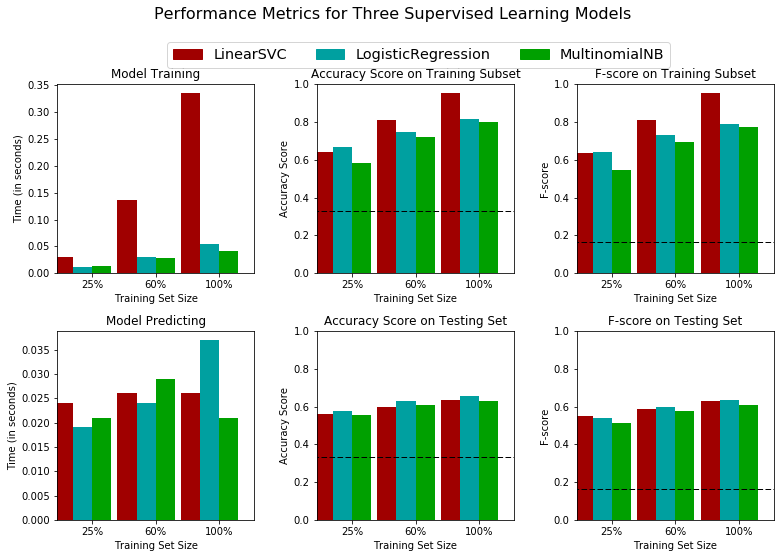

In [90]:
# Set candidate models
clf_A = MultinomialNB()
clf_B = LogisticRegression()
clf_C = LinearSVC(multi_class="crammer_singer")

# Calculate the number of samples for 25%, 60%, and 100% of the training data
samples_25 = int(0.25 * len(X_train))
samples_60 = int(0.60 * len(X_train))
samples_100 = len(X_train)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_25, samples_60, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, train_vectors, y_train, test_vectors, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

### Fine-tuning selected model - Logistic Regression (with TFIDF data)

In [25]:
# Performance of the default Logistic Regression model
clf = LogisticRegression()
clf.fit(train_vectors, y_train)
pred = clf.predict(test_vectors)
print ("F1-score: {:.2f}" .format(f1_score(y_test, pred, average="weighted")))
print ("Accuracy: {:.2f}" .format(accuracy_score(y_test, pred)))

F1-score: 0.63
Accuracy: 0.66


In [55]:
# Fine-tuning the Logistic Regression model 
clf = LogisticRegression() 
param_grid = {
              "C": np.linspace(0.1, 5, 11),
              #"penalty": ["l1", "l2"], 
              #"dual": [True, False], 
              #"class_weight": [None, "balanced"],
              "solver" : ["newton-cg", "lbfgs"]
              #"multi_class": ["ovr", "multinomial"],
              #"warm_start": [True, False]
             }
#cv_sets = StratifiedShuffleSplit(n_splits = 5, test_size = 0.25, random_state = 0)
#f1 = make_scorer(f1_score, average="weighted") #labels = [0, 1, 2, 3]) 
clf_cv = GridSearchCV(clf, param_grid, scoring=None, cv=4)
clf_cv.fit(train_vectors, y_train)

GridSearchCV(cv=4, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([ 0.1 ,  0.59,  1.08,  1.57,  2.06,  2.55,  3.04,  3.53,  4.02,
        4.51,  5.  ]), 'solver': ['newton-cg', 'lbfgs']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [56]:
# Print optimized parameters
print ("Best parameters per GridsearchCV: ", clf_cv.best_params_)
clf_cv.best_score_
# Derive the best model and check its performance
best = clf_cv.best_estimator_
pred = best.predict(test_vectors)
print ("F1-score: {:.2f}" .format(f1_score(y_test, pred, average="weighted")))
print ("Accuracy: {:.2f}" .format(accuracy_score(y_test, pred)))
# Save and retrieve best model 
#from sklearn.externals import joblib
#joblib.dump(clf, 'best.pkl') 
#best = joblib.load('best.pkl') 

Best parameters per GridsearchCV:  {'C': 1.5700000000000003, 'solver': 'newton-cg'}
F1-score: 0.64
Accuracy: 0.66


### Final model evaluation

In [23]:
# View classification report
print ("Classification report")
print(classification_report(y_test, pred))

Classification report
             precision    recall  f1-score   support

          0       0.69      0.75      0.72       316
          1       0.66      0.76      0.71       312
          2       0.61      0.59      0.60       184
          3       0.53      0.20      0.29       107

avg / total       0.65      0.66      0.64       919



In [30]:
# Define confusion matrix plotting function 
# Note: this function was borrowed from http://scikit-learn.org resources
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


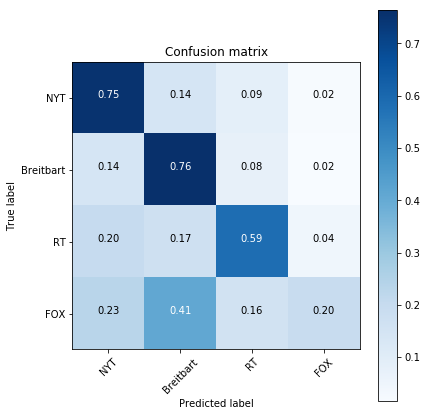

In [31]:
# Plot confusion matrix
plot_confusion_matrix(confusion_matrix(y_test, pred), ["NYT", "Breitbart", "RT", "FOX"], \
                     normalize=True)

### Extracting feature importance with Random Forest classifier

In [35]:
# Define and check the performance of Random Forest classifier 
rf_clf = RandomForestClassifier()
rf_clf.fit(train_vectors, y_train)
pred = rf_clf.predict(test_vectors)
print ("F1-score: {:.2f}" .format(f1_score(y_test, pred, average="weighted")))
print ("Accuracy: {:.2f}" .format(accuracy_score(y_test, pred)))

F1-score: 0.62
Accuracy: 0.64


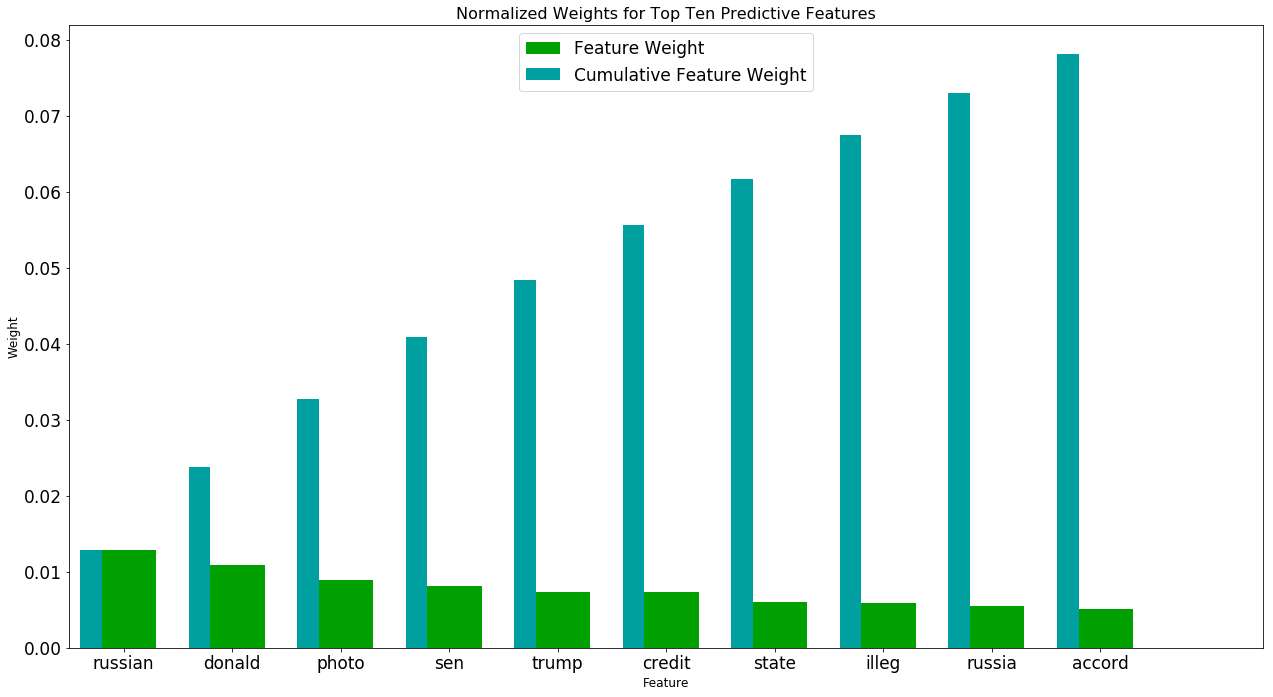

In [39]:
# Extract the feature importances
importances = rf_clf.feature_importances_

# Plot feature importances
mpl.rcParams["font.size"] = 17
vs.feature_plot(importances, train_vectors, y_train)